# 02. PyTorch Neural Network Classification

## 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [2]:
print(f'First 5 X features:\n{X[:5]}')
print(f'\nFirst 5 y labels:\n{y[:5]}')

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0],
    'X2': X[:, 1],
    'label': y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

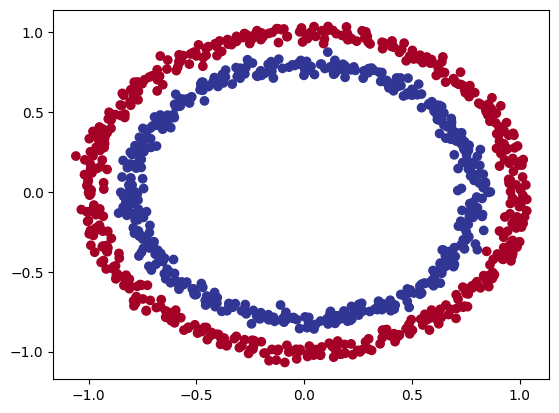

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 Input and output shapes

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [8]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

In [10]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # take in 5 features, produces 1 feature (5)

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f'Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Length of test samples: {len(y_test)}, Shape: {y_test.shape}')
print(f'\nFirst 10 predictions:\n{untrained_preds[:10]}')
print(f'\nFirst 10 test labels:\n{y_test[:10]}')

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.3838],
        [0.4216],
        [0.2860],
        [0.4115],
        [0.2881],
        [0.3112],
        [0.4160],
        [0.3901],
        [0.2860],
        [0.4242]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

In [14]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [15]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train Model

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [16]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.3838],
        [0.4216],
        [0.2860],
        [0.4115],
        [0.2881]], device='cuda:0', grad_fn=<SliceBackward0>)

In [17]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5948],
        [0.6039],
        [0.5710],
        [0.6014],
        [0.5715]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [18]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [19]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Buidling a training and testing loop

In [20]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra '1' dimensions, this won't work unless model and data are on the same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                              y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optmizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 3. Calculate loss/accuracy
        test_loss = loss_fn(test_logits,
                             y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')
print(y_pred.dtype)

Epoch: 0 | Loss: 0.70713, Accuracy: 50.00% | Test loss: 0.70924, Test acc: 50.00%
Epoch: 10 | Loss: 0.69936, Accuracy: 50.00% | Test loss: 0.70082, Test acc: 50.00%
Epoch: 20 | Loss: 0.69591, Accuracy: 50.00% | Test loss: 0.69694, Test acc: 50.00%
Epoch: 30 | Loss: 0.69438, Accuracy: 50.00% | Test loss: 0.69517, Test acc: 50.00%
Epoch: 40 | Loss: 0.69370, Accuracy: 50.00% | Test loss: 0.69436, Test acc: 50.00%
Epoch: 50 | Loss: 0.69339, Accuracy: 50.00% | Test loss: 0.69401, Test acc: 50.00%
Epoch: 60 | Loss: 0.69324, Accuracy: 59.25% | Test loss: 0.69388, Test acc: 56.50%
Epoch: 70 | Loss: 0.69316, Accuracy: 53.75% | Test loss: 0.69385, Test acc: 52.50%
Epoch: 80 | Loss: 0.69311, Accuracy: 52.75% | Test loss: 0.69387, Test acc: 52.00%
Epoch: 90 | Loss: 0.69308, Accuracy: 51.88% | Test loss: 0.69391, Test acc: 49.00%
torch.float32


## 4. Make predictions and evaluate the model

In [21]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists, skipping download')
else:
    print('Downloading helper_functions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


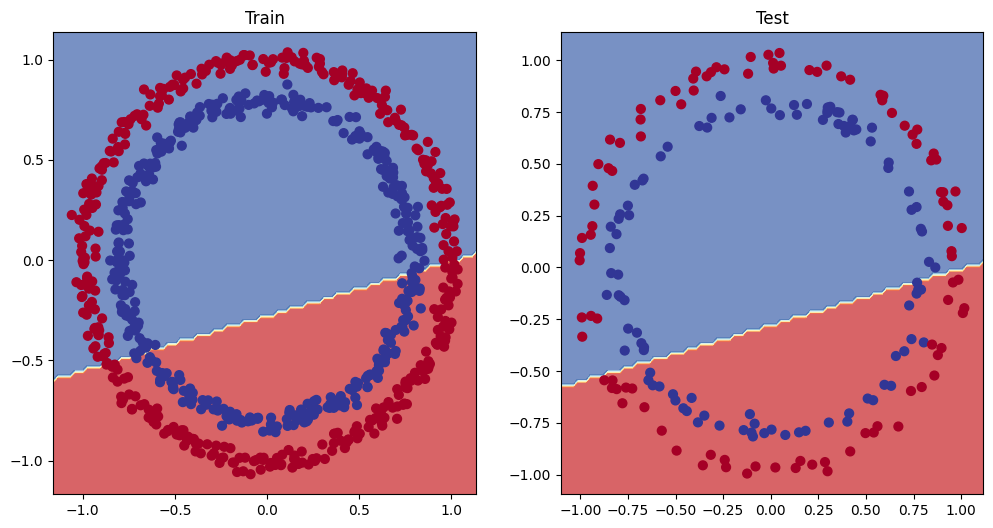

In [22]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

In [23]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [25]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grasd
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    #5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}')

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00


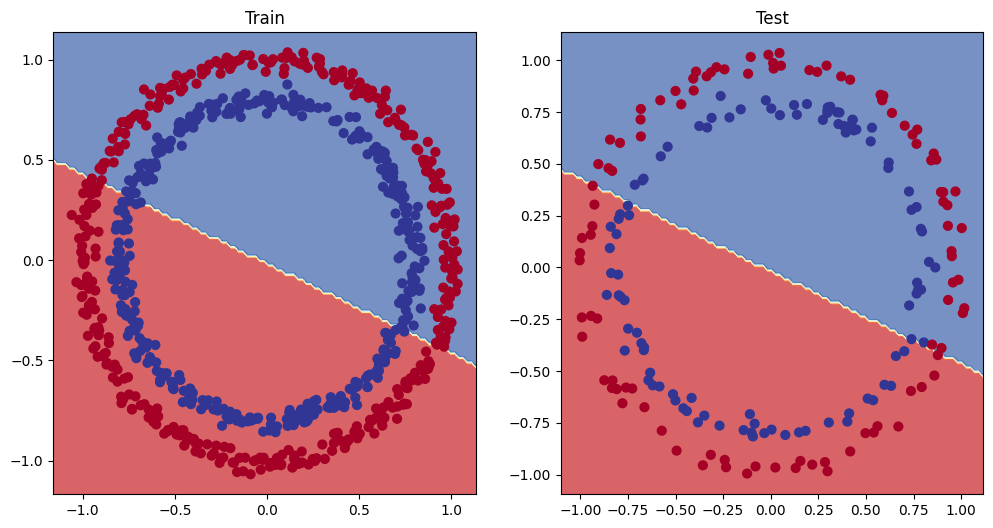

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can model a straight line

In [27]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # lienar regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [28]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
      len(y_train_regression),
      len(X_train_regression),
      len(y_test_regression))

80 80 80 20


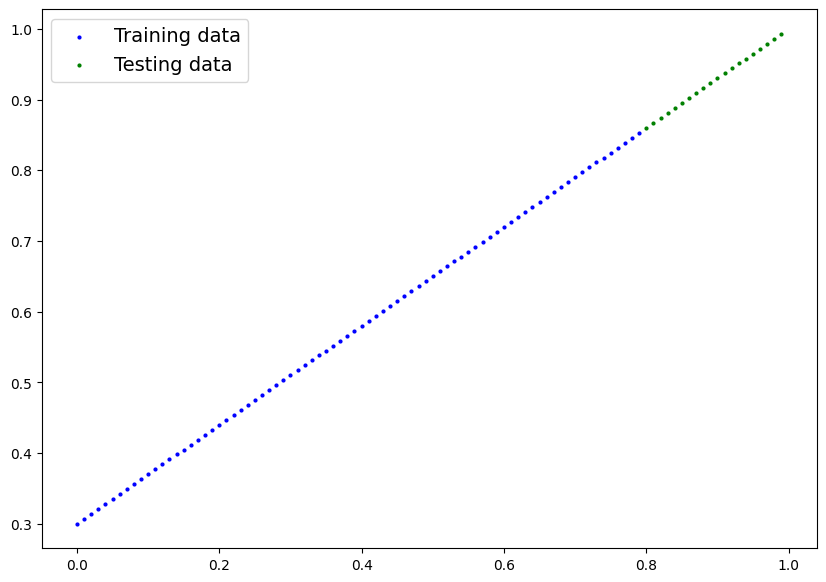

In [29]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression
);

### 5.2 Adjusting `model_1` to fit a straight line

In [30]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [32]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calcualte loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_2(X_test_regression)
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f'Epoch : {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}')

Epoch : 0 | Train loss: 0.75986, Test loss: 0.54143


Epoch : 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch : 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch : 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch : 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch : 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch : 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch : 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch : 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch : 900 | Train loss: 0.05571, Test loss: 0.00603


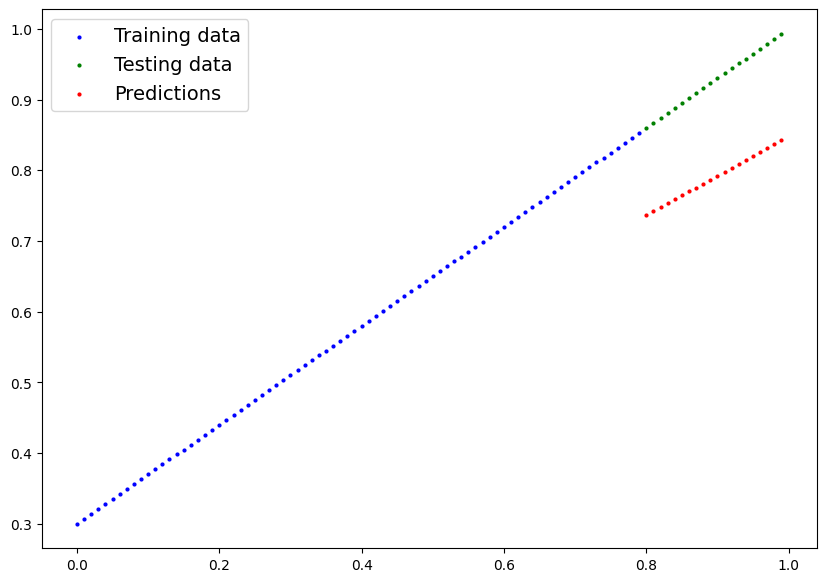

In [33]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and prediction with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

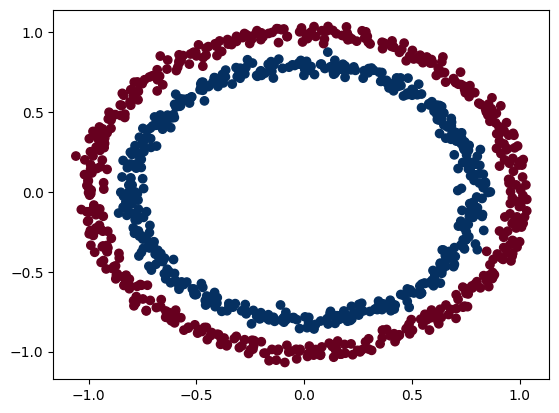

In [34]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42,
                    )

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [35]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                   )

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [36]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [37]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.2)

### 6.3 Training a model with non-linearity

In [38]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
        # 2. Calculate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69312, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.68978, Accuracy: 53.37% | Test Loss: 0.68938, Test Accuracy: 55.50%
Epoch: 200 | Loss: 0.68518, Accuracy: 52.75% | Test Loss: 0.68409, Test Accuracy: 56.50%
Epoch: 300 | Loss: 0.67520, Accuracy: 54.37% | Test Loss: 0.67282, Test Accuracy: 56.50%
Epoch: 400 | Loss: 0.65179, Accuracy: 63.88% | Test Loss: 0.64756, Test Accuracy: 67.50%
Epoch: 500 | Loss: 0.56917, Accuracy: 87.50% | Test Loss: 0.57400, Test Accuracy: 86.50%
Epoch: 600 | Loss: 0.37245, Accuracy: 97.88% | Test Loss: 0.40668, Test Accuracy: 92.50%
Epoch: 700 | Loss: 0.30881, Accuracy: 87.12% | Test Loss: 0.34613, Test Accuracy: 81.50%
Epoch: 800 | Loss: 0.09464, Accuracy: 99.88% | Test Loss: 0.13391, Test Accuracy: 99.50%
Epoch: 900 | Loss: 0.05634, Accuracy: 99.88% | Test Loss: 0.08544, Test Accuracy: 99.50%


### 6.4 Evaluating a model trained with non-linear activation functions

In [39]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

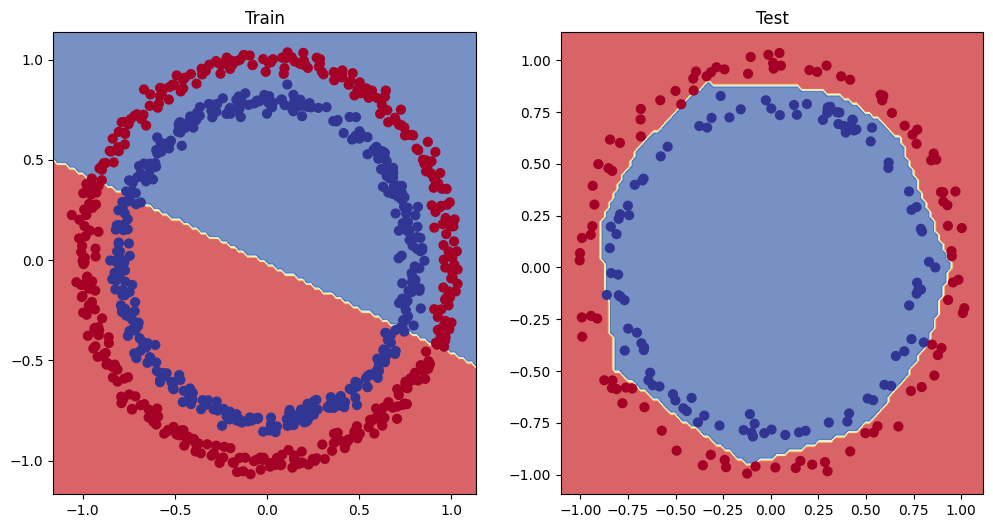

In [40]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## 7. Replication non-linear activation functions

In [41]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

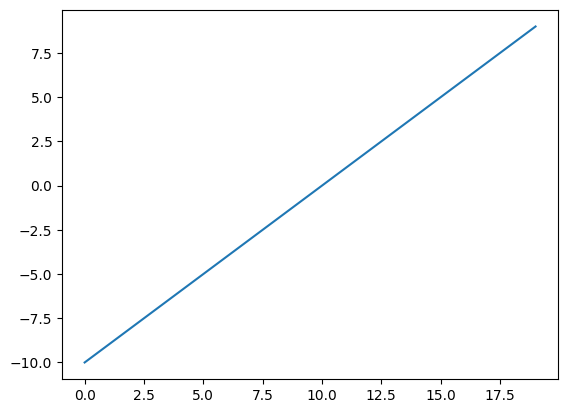

In [42]:
# Visualize the toy tensor
plt.plot(A);

In [43]:
# Create ReLU function by hand
def relu(x):
    return torch.maximum(torch.tensor(0), x)# inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

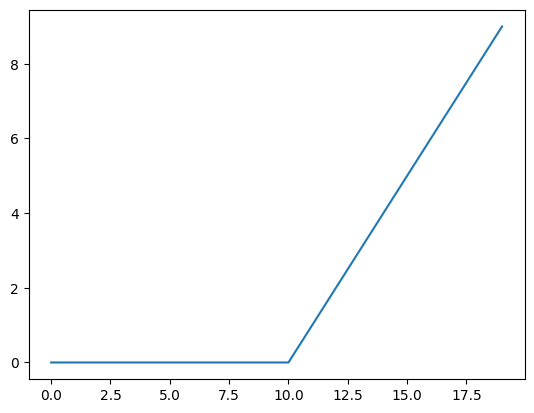

In [44]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

In [45]:
# Create a custom sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

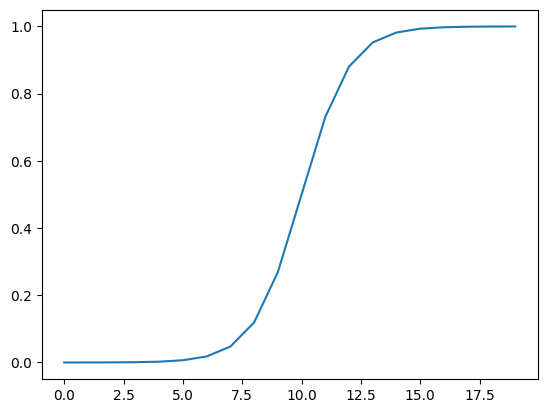

In [46]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

## 8. Putting things together by building a multi-class PyTorch model

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


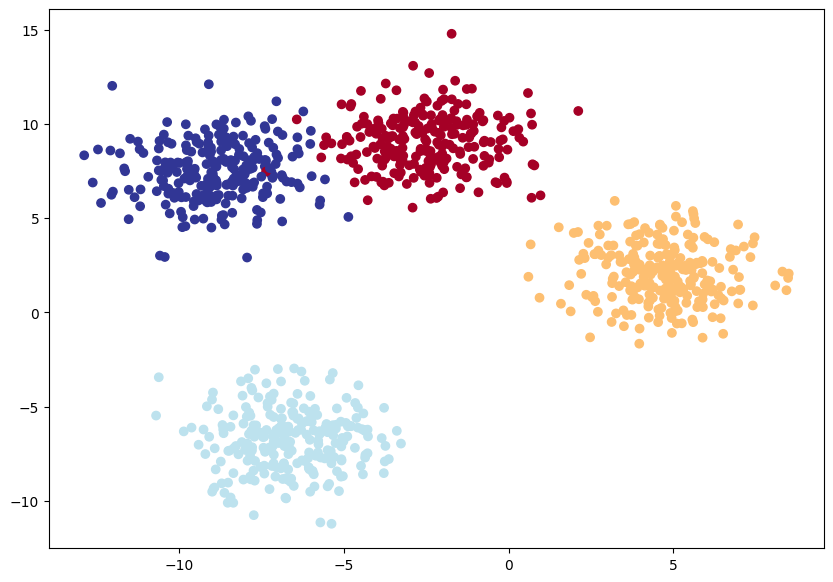

In [47]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES, # X features
                            centers=NUM_CLASSES, # y labels
                            cluster_std=1.5, # give the clusters a little shake up (try chaning this to 1.0, the default)
                            random_state=RANDOM_SEED
                            )

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED
                                                                        )

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in PyTorch

In [48]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [49]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
                (how many classes there are)
            hidden_units (int): Number of hidden units between layers, default 8.
        """

        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Creating a loss function and optimzer for a multi-class PyTorch model

In [50]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.2) # exercise: try changing the learning rate here and see what happens to the model's performance

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [51]:
# Perform a single forward pass on the data (we'll need to put it to the target device)
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [52]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [53]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [54]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [55]:
# Which class does the model thing is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


### 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [56]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model output raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=(test_pred))

    # Print out what's happening
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.44162, Test Acc: 80.00%
Epoch: 10 | Loss: 0.07975, Acc: 99.12% | Test Loss: 0.06796, Test Acc: 99.50%
Epoch: 20 | Loss: 0.04851, Acc: 99.12% | Test Loss: 0.03955, Test Acc: 99.50%
Epoch: 30 | Loss: 0.03893, Acc: 99.00% | Test Loss: 0.03018, Test Acc: 99.50%
Epoch: 40 | Loss: 0.03440, Acc: 99.12% | Test Loss: 0.02550, Test Acc: 99.50%
Epoch: 50 | Loss: 0.03180, Acc: 99.12% | Test Loss: 0.02269, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03014, Acc: 99.12% | Test Loss: 0.02081, Test Acc: 99.50%
Epoch: 70 | Loss: 0.02900, Acc: 99.12% | Test Loss: 0.01945, Test Acc: 99.50%
Epoch: 80 | Loss: 0.02817, Acc: 99.12% | Test Loss: 0.01843, Test Acc: 99.50%
Epoch: 90 | Loss: 0.02755, Acc: 99.12% | Test Loss: 0.01763, Test Acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [57]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 5.4111e+00,  1.2954e+01, -1.7911e+01, -1.1807e+01],
        [ 5.6307e+00, -1.5261e+01,  3.9044e+00,  1.2558e+01],
        [-7.1827e+00, -1.6452e+01,  2.5129e+01,  1.5272e+01],
        [ 2.3264e+00,  9.5440e+00, -1.0348e+01, -8.4536e+00],
        [ 9.7246e+00,  3.9024e+00, -1.7631e+01, -4.5486e+00],
        [ 6.2404e+00, -1.8955e+01,  5.8407e+00,  1.5671e+01],
        [-7.5632e+00, -1.2466e+01,  2.2601e+01,  1.1876e+01],
        [ 8.4150e+00, -1.1539e+00, -1.1586e+01, -4.9759e-03],
        [-7.3265e+00, -2.3066e+01,  3.0552e+01,  2.1009e+01],
        [ 8.7421e+00,  6.9868e-01, -1.3559e+01, -1.6497e+00]], device='cuda:0')

In [58]:
# Turn predicted logits into prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilites into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f'Prediction: {y_preds[:10]}\nLabels: {y_blob_test[:10]}')
print(f'Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%')

Prediction: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


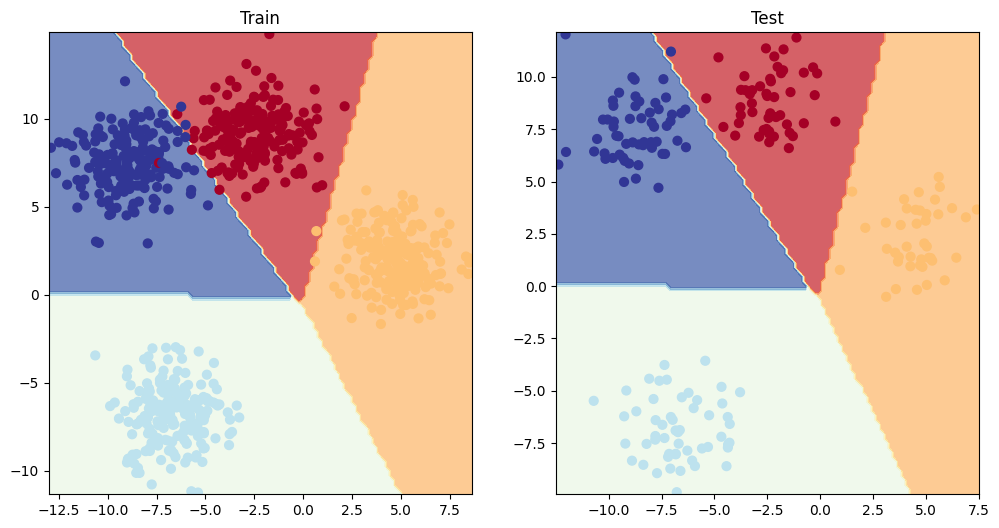

In [59]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. More classification evaluation metrics

In [60]:
print(y_preds.dtype)
try:
    from torchmetrics import Accuracy
except:
    %pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)
print(y_preds.dtype)

torch.int64
torch.int64


## Exercises

1. Make a binary classification dataset with Scikit-Learn's `make_moons()` function.
* For consistency, the dataset should have 1000 samples and a `random_state=42`.
* Turn the data into PyTorch tensors. Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [61]:
# Imports
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Data hyperparameters
N_SAMPLES = 1000
RANDOM_SEED = 42

#Test split hyperparameters
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Create data
X, y = make_moons(n_samples=N_SAMPLES,
                  random_state=RANDOM_SEED)

# Visualize data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);
plt.xlabel('X[:, 0]');
plt.ylabel('X[:, 1]');

# Turn data into PyTorch tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

Error in callback <function flush_figures at 0x7f668adced40> (for post_execute):


KeyboardInterrupt: 

2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
* Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [ ]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

# Build model with non-linear activation function
from torch import nn
class MoonModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes all required hyperparameters for a binary classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model.
            hidden_units (int): Number of hidden units between layers, default 8.
        """

        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of MoonModel and send it to the target device
model_ex = MoonModel(input_features=2,
                    output_features=1,
                    hidden_units=8).to(device)
model_ex

Using cuda


MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_ex.parameters(),
                            lr=0.1)

4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
* To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
* Train the model for long enough for it to reach over 96% accuracy.
* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [ ]:
# Import accuracy
from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
accuracy_fn = Accuracy(task='binary', num_classes=2).to(device)

# Fit the model
torch.manual_seed(42)
epochs = 700

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_ex(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probs -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogits calculates loss using logits
    acc = accuracy_fn(y_pred.to(torch.int), y_train.to(torch.int))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimzer step
    optimizer.step()

    ### Testing
    model_ex.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_ex(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probs -> prediction labels
        # 2. Calculate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_pred.to(torch.int), y_test.to(torch.int))

    # Print out what's happening
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%')

if test_acc > 0.96:
    print('Passes accuracy threshold!')
else:
    print('Accuracy too low!')

Epoch: 0 | Loss: 0.71196, Accuracy: 0.50% | Test Loss: 0.70563, Test Accuracy: 0.50%
Epoch: 10 | Loss: 0.69015, Accuracy: 0.62% | Test Loss: 0.68805, Test Accuracy: 0.63%
Epoch: 20 | Loss: 0.67909, Accuracy: 0.80% | Test Loss: 0.67865, Test Accuracy: 0.83%
Epoch: 30 | Loss: 0.66615, Accuracy: 0.84% | Test Loss: 0.66675, Test Accuracy: 0.84%
Epoch: 40 | Loss: 0.64657, Accuracy: 0.82% | Test Loss: 0.64825, Test Accuracy: 0.82%
Epoch: 50 | Loss: 0.61696, Accuracy: 0.81% | Test Loss: 0.62022, Test Accuracy: 0.82%
Epoch: 60 | Loss: 0.57481, Accuracy: 0.81% | Test Loss: 0.58025, Test Accuracy: 0.82%
Epoch: 70 | Loss: 0.51999, Accuracy: 0.81% | Test Loss: 0.52830, Test Accuracy: 0.83%
Epoch: 80 | Loss: 0.45935, Accuracy: 0.83% | Test Loss: 0.47058, Test Accuracy: 0.82%
Epoch: 90 | Loss: 0.40350, Accuracy: 0.84% | Test Loss: 0.41693, Test Accuracy: 0.81%
Epoch: 100 | Loss: 0.36001, Accuracy: 0.85% | Test Loss: 0.37441, Test Accuracy: 0.83%
Epoch: 110 | Loss: 0.32850, Accuracy: 0.85% | Test Los

Epoch: 250 | Loss: 0.22416, Accuracy: 0.89% | Test Loss: 0.22536, Test Accuracy: 0.90%
Epoch: 260 | Loss: 0.22231, Accuracy: 0.90% | Test Loss: 0.22320, Test Accuracy: 0.91%
Epoch: 270 | Loss: 0.22053, Accuracy: 0.90% | Test Loss: 0.22114, Test Accuracy: 0.91%
Epoch: 280 | Loss: 0.21879, Accuracy: 0.90% | Test Loss: 0.21913, Test Accuracy: 0.91%
Epoch: 290 | Loss: 0.21704, Accuracy: 0.90% | Test Loss: 0.21715, Test Accuracy: 0.92%
Epoch: 300 | Loss: 0.21527, Accuracy: 0.90% | Test Loss: 0.21518, Test Accuracy: 0.92%
Epoch: 310 | Loss: 0.21346, Accuracy: 0.90% | Test Loss: 0.21319, Test Accuracy: 0.92%
Epoch: 320 | Loss: 0.21160, Accuracy: 0.90% | Test Loss: 0.21117, Test Accuracy: 0.92%
Epoch: 330 | Loss: 0.20967, Accuracy: 0.90% | Test Loss: 0.20910, Test Accuracy: 0.92%
Epoch: 340 | Loss: 0.20766, Accuracy: 0.90% | Test Loss: 0.20696, Test Accuracy: 0.92%
Epoch: 350 | Loss: 0.20556, Accuracy: 0.90% | Test Loss: 0.20475, Test Accuracy: 0.92%
Epoch: 360 | Loss: 0.20336, Accuracy: 0.90%

5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

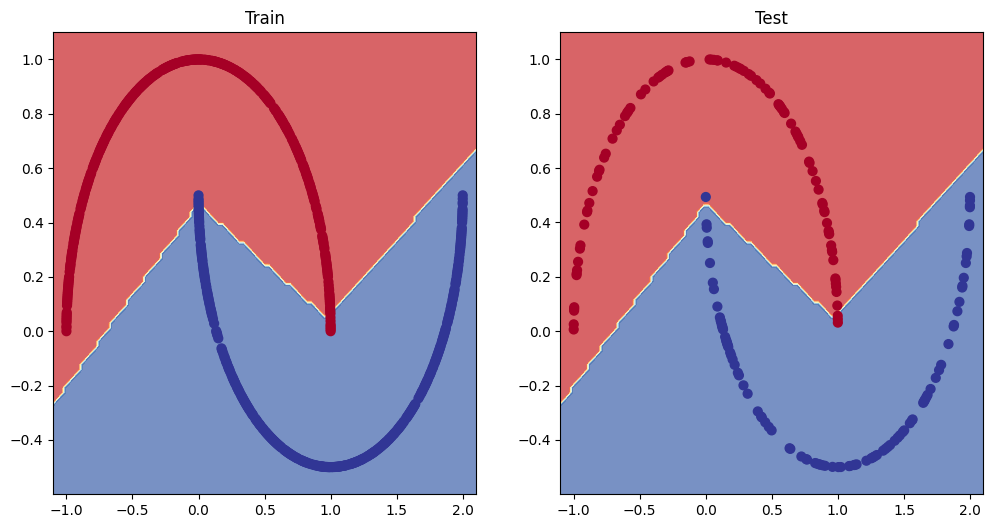

In [ ]:
# Make predictions
model_ex.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_ex(X_test))).squeeze()

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_ex, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_ex, X_test, y_test)

6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
* Feel free to reference the ML cheatsheet website for the formula.

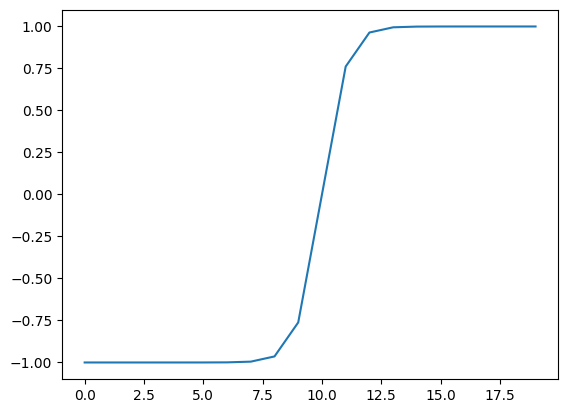

In [ ]:
# Create a custom tanh function
def torch_tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

# Plot tanh activated toy tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
plt.plot(torch_tanh(A))

7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
* Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

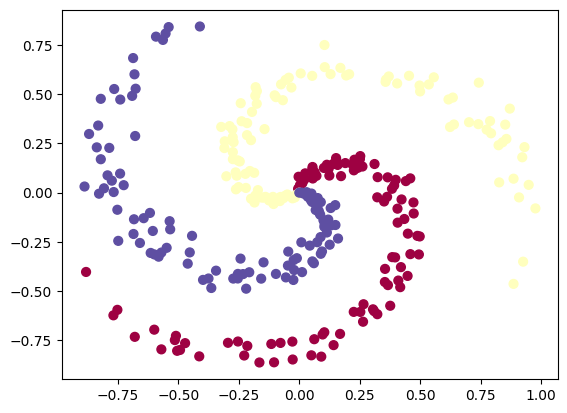

Device: cuda
SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)
Epoch: 0 | Loss: 1.10175, Accuracy: 0.32% | Test Loss: 1.08897, Test Accuracy: 0.37%
Epoch: 1000 | Loss: 0.42179, Accuracy: 0.80% | Test Loss: 0.44566, Test Accuracy: 0.73%
Epoch: 2000 | Loss: 0.24858, Accuracy: 0.89% | Test Loss: 0.19721, Test Accuracy: 0.87%
Epoch: 3000 | Loss: 0.13541, Accuracy: 0.95% | Test Loss: 0.09409, Test Accuracy: 0.90%
Epoch: 4000 | Loss: 0.09217, Accuracy: 0.97% | Test Loss: 0.05905, Test Accuracy: 0.90%
Epoch: 5000 | Loss: 0.06312, Accuracy: 0.98% | Test Loss: 0.03511, Test Accuracy: 0.90%
Epoch: 6000 | Loss: 0.05373, Accuracy: 0.98% | Test Loss: 0.02500, Test Accuracy: 0.90%
Epoch: 7000 | Loss: 0.04545, Accuracy: 0.98% | Test Loss: 0.01807, Test Accuracy: 0.92%
Epoch: 8000 | Loss: 0.040

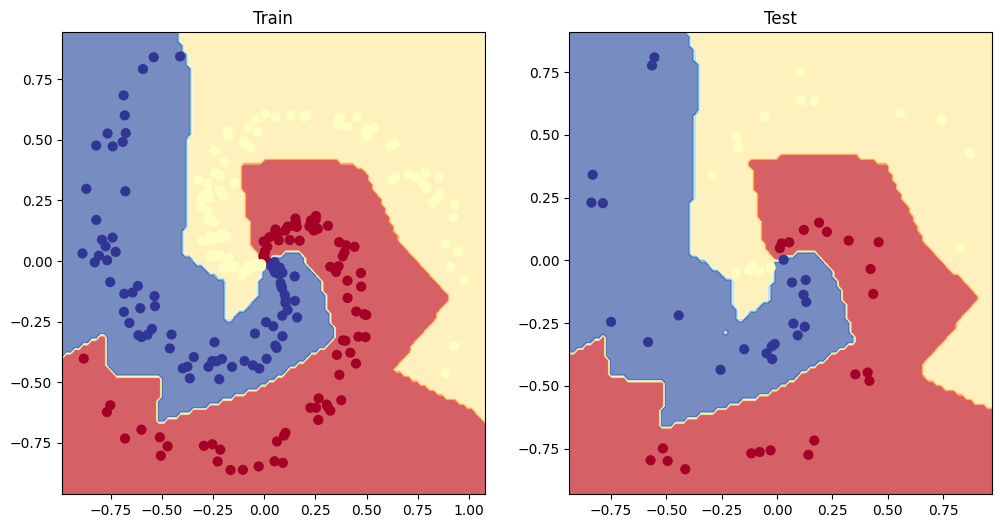

In [ ]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

# 2. Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# 3. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

#Build model
class SpiralModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            output_features (int): Number of ouput features from the model.
            hidden_units (int): Number of hidden units between layers, default 8.
        """

        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of SpiralModel and send it to the target device
model_sp = SpiralModel(input_features=D,
                       output_features=K,
                       hidden_units=8).to(device)
print(model_sp)

# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sp.parameters(),
                            lr=0.1)

# Create accuracy function
accuracy_fn = Accuracy(task='multiclass',
                       num_classes=K).to(device)

# Fit the model
torch.manual_seed(42)
epochs = 20000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_sp.train()

    # 1. Forward pass
    y_logits = model_sp(X_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_preds, y_train.to(torch.int))

    # 3. Optmizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_sp.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_sp(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_preds, y_test.to(torch.int))

    # Print out what's happening
    if epoch % 1000 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%')

if test_acc > 0.95:
    print('Passes accuracy threshold!')
else:
    print('Accuracy too low!')

# Make predictions
model_sp.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_sp(X_test))).squeeze()

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_sp, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_sp, X_test, y_test)

In [ ]:
print(test_preds.shape)

torch.Size([60, 3])
